In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

* 沪深300指数20年5月6日开盘价为3867.26，21年4月30日开盘价为 5156.36元，收益率为33.3%

# 构建股票投资组合，数据获取。
从沪深300指数中任意选取5只股票构建投资组合，总资金100万。
资金分配权重为初始时刻在指数中的权重。
回测区间：2020/5/1 - 2021/5/1

In [4]:
#2020/5/1 - 2021/5/1 从Tushare获取数据
import tushare as ts
pro = ts.pro_api()
hs300_weight = ts.get_hs300s()

In [5]:
#策略1 收益序列
keep = []
simple_op = []
move_op = []

In [6]:
for i in range(1000):
    try:
        import random
        hs300_list = [x for x in range(0,300)]
        random.shuffle(hs300_list)
        hs300_choice5 = hs300_list[0:5]

        hs300_choice5 = hs300_weight.loc[hs300_choice5]
        print(hs300_choice5)

        hs300_choice5.reset_index(inplace = True)
        hs300_choice5['invest_weight'] = hs300_choice5['weight']/sum( hs300_choice5['weight']) 
        for i in range(len(hs300_choice5['code'])):
            if str(hs300_choice5.loc[i,'code'])[0] != '6':
                hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SZ'
            else:
                hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SH'
        
        time_on = '20200501'
        time_off = '20210501'
        df_ldkg = pro.daily(ts_code=str(hs300_choice5['code'][0]), start_date=time_on, end_date=time_off)
        df_zssk = pro.daily(ts_code=str(hs300_choice5['code'][1]), start_date=time_on, end_date=time_off)
        df_ztdq = pro.daily(ts_code=str(hs300_choice5['code'][2]), start_date=time_on, end_date=time_off)
        df_zgtb = pro.daily(ts_code=str(hs300_choice5['code'][3]), start_date=time_on, end_date=time_off)
        df_xbzq = pro.daily(ts_code=str(hs300_choice5['code'][4]), start_date=time_on, end_date=time_off)

#invest_vol 初始投资额
#invest_weight 投资比重
#初始投资80万  20万留作剩余现金
        hs300_choice5['invest_vol'] = hs300_choice5['invest_weight'] * 1000000*0.8

#将数据按照日期进行排序
        df_ldkg = df_ldkg.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_zssk = df_zssk.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_ztdq = df_ztdq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_zgtb = df_zgtb.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_xbzq = df_xbzq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)

#stock_daily——将五只股票的2020年5月6日的 ['ts_code','trade_date','open','close'] [股票代码，交易日期，开盘价，收盘价]拼接在一起
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
        daily_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[0],stock_list[1][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
        n = 2
        while n <5:
            daily_data = pd.concat([daily_data,stock_list[n][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
            n = n + 1
        stock_daily = daily_data.T

#hs300_choice5 沪深300的选择的五只股票的基本信息
        hs300_choice5 = hs300_choice5.reset_index()#重置索引

        hs300_choice5['ts_code'] = hs300_choice5['code']
        hs300_choice5.drop('code',axis =1,inplace =True)

#将stock_daily 与 股票详细信息拼接在一起
        stock_daily  = pd.merge(stock_daily,hs300_choice5[['name','invest_weight','invest_vol','ts_code']],on = 'ts_code')

        stock_daily['trade_cost'] = stock_daily['invest_vol'] * 0.00025#计算交易费用
        for i in stock_daily['trade_cost']:
            if i < 5:
                i = 5
        stock_daily['price_in'] = stock_daily['open']
        stock_daily['stock_num'] = stock_daily['invest_vol'] / stock_daily['price_in']
        #求2020年5月6日的现金剩余现金 trade_cost交易费用
        cash_remain = 1000000 - sum(stock_daily['trade_cost'] ) - sum(stock_daily['invest_vol'])
        print('开仓剩余现金为：',cash_remain)

#final_daily 2021年4月30日的股票详细信息 和 stock_daily 同理
        final_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[242],stock_list[1][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
        n = 2
        while n <5:
            final_data = pd.concat([final_data,stock_list[n][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
            n = n + 1
        final_daily = final_data.T

        stock_daily = pd.merge(stock_daily,final_daily[['ts_code','open']],on = 'ts_code')
        stock_daily['price_out'] = stock_daily['open_y']
        stock_daily['trade_cost_out'] = stock_daily['price_out']* stock_daily['stock_num']*(0.01 + 0.00025)#股票卖出的交易费用 包含印花税
        for i in  stock_daily['trade_cost_out']:
            if i < 0:
                i = 0
        stock_daily['harvest_vol'] = stock_daily['price_out']* stock_daily['stock_num']

#21年4月30日卖出股票 计算剩余现金
        cash_remain = cash_remain -sum(stock_daily['trade_cost_out']) + sum(stock_daily['harvest_vol'])
        print('平仓剩余现金为：',cash_remain)
        mark_1 = cash_remain
#策略1收益率
        mark_rate_1 = mark_1/1000000 - 1
        print('策略1收益率为',mark_rate_1)

############计算均线
# 简单平均
        def smaCal(tsPrice, k):  # 输入价格序列,Series
            Sma = pd.Series(np.nan, index = list(range(len(tsPrice))))
            for i in range(k - 1, len(tsPrice)):
                Sma[i] = sum(tsPrice[(i - k + 1):(i + 1)]) / k
            Sma.index = tsPrice.index
            return (Sma)

# 加权平均
        def wmaCal(tsPrice, weight):  # 输入价格序列,Series
            k = len(weight)
            arrWeight = np.array(weight)
            Wma = pd.Series(np.nan, index = list(range(len(tsPrice))))
            for i in range(k - 1, len(tsPrice.index)):
                Wma[i] = sum(arrWeight * tsPrice[(i - k + 1):(i + 1)])
            Wma.index = tsPrice.index
            return (Wma)

        def _ema(tsprice):
            temple = tsprice.index
            tsprice.index = list(range(len(tsprice)))
            N = len(tsprice)
            alpha = 2/(N+1)
            data = np.zeros(len(tsprice))
            for i in range(len(data)):
                data[i] = tsprice[i] if i==0 else alpha*tsprice[i]+(1-alpha)*data[i-1]
            return data[-1]
        def ewmaCal(tsprice,period):
            temple = tsprice.index
            tsprice.index = list(range(len(tsprice)))
            data = pd.Series(np.nan ,index = list(range(len(tsprice))))
            for i in range(period-1,len(tsprice)):
                data[i] = _ema(tsprice[i+1-period:i+1])
            data.index = temple
            return data

        for i in stock_list:
            i.index = i['trade_date']
    
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
        df_ldkg_mean5 = df_ldkg[['trade_date','close']]

#简单平均
        df_ldkg_mean5 = smaCal(df_ldkg_mean5['close'],5)
        df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)
#加权平均
        df_ldkg_mean5 = df_ldkg[['trade_date','close']]
        weight = [0.10,0.15,0.20,0.25,0.30]#权重列表      
        df_ldkg_mean5 = wmaCal(df_ldkg_mean5['close'],weight)
        df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

# 指数移动平均
        df_ldkg_mean5 = df_ldkg[['trade_date','close']]    
        df_ldkg_mean5 = ewmaCal(df_ldkg_mean5['close'],period=5)
        df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg_simple5 = smaCal(df_ldkg['close'],5)
        df_zssk_simple5 = smaCal(df_zssk['close'],5)
        df_ztdq_simple5 = smaCal(df_ztdq['close'],5)
        df_zgtb_simple5 = smaCal(df_zgtb['close'],5)
        df_xbzq_simple5 = smaCal(df_xbzq['close'],5)
        stockprice_simple5 = pd.DataFrame([df_ldkg_simple5,df_zssk_simple5,df_ztdq_simple5,df_zgtb_simple5,df_xbzq_simple5])
        stockprice_simple5 = stockprice_simple5.T
        stockprice_simple5.index = df_ldkg['trade_date']
        stockprice_simple5.columns = ['df_ldkg_simple5','df_zssk_simple5','df_ztdq_simple5','df_zgtb_simple5','df_xbzq_simple5']
        
        df_ldkg_simple20 = smaCal(df_ldkg['close'],20)
        df_zssk_simple20 = smaCal(df_zssk['close'],20)
        df_ztdq_simple20 = smaCal(df_ztdq['close'],20)
        df_zgtb_simple20 = smaCal(df_zgtb['close'],20)
        df_xbzq_simple20 = smaCal(df_xbzq['close'],20)
        stockprice_simple20 = pd.DataFrame([df_ldkg_simple20,df_zssk_simple20,df_ztdq_simple20,df_zgtb_simple20,df_xbzq_simple20])
        stockprice_simple20 = stockprice_simple20.T
        stockprice_simple20.index = df_ldkg['trade_date']
        stockprice_simple20.columns = ['df_ldkg_simple20','df_zssk_simple20','df_ztdq_simple20','df_zgtb_simple20','df_xbzq_simple20']
        
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg_mean5 = ewmaCal(df_ldkg['close'],period=5)
        df_zssk_mean5 = ewmaCal(df_zssk['close'],period=5)
        df_ztdq_mean5 = ewmaCal(df_ztdq['close'],period=5)
        df_zgtb_mean5 = ewmaCal(df_zgtb['close'],period=5)
        df_xbzq_mean5 = ewmaCal(df_xbzq['close'],period=5)
        stockprice_mean5 = pd.DataFrame([df_ldkg_mean5,df_zssk_mean5,df_ztdq_mean5,df_zgtb_mean5,df_xbzq_mean5])
        stockprice_mean5 = stockprice_mean5.T
        stockprice_mean5.index = df_ldkg['trade_date']
        stockprice_mean5.columns = ['df_ldkg_mean5','df_zssk_mean5','df_ztdq_mean5','df_zgtb_mean5','df_xbzq_mean5']
        
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg_mean20 = ewmaCal(df_ldkg['close'],period=20)
        df_zssk_mean20 = ewmaCal(df_zssk['close'],period=20)
        df_ztdq_mean20 = ewmaCal(df_ztdq['close'],period=20)
        df_zgtb_mean20 = ewmaCal(df_zgtb['close'],period=20)
        df_xbzq_mean20 = ewmaCal(df_xbzq['close'],period=20)
        stockprice_mean20 = pd.DataFrame([df_ldkg_mean20,df_zssk_mean20,df_ztdq_mean20,df_zgtb_mean20,df_xbzq_mean20])
        stockprice_mean20 = stockprice_mean20.T
        stockprice_mean20.columns = ['df_ldkg_mean20','df_zssk_mean20','df_ztdq_mean20','df_zgtb_mean20','df_xbzq_mean20']
        stockprice_mean20.index = df_ldkg['trade_date']
        
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg = df_ldkg[['ts_code','open','close']]
        df_zssk = df_zssk[['ts_code','open','close']]
        df_ztdq = df_ztdq[['ts_code','open','close']]
        df_zgtb = df_zgtb[['ts_code','open','close']]
        df_xbzq = df_xbzq[['ts_code','open','close']]
        
        #将每个股票的各种均线合并到一个表中
        merge_list = [df_ldkg_mean5,df_ldkg_mean20,df_ldkg_simple5,df_ldkg_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_ldkg.index
            
        for df  in merge_list:
            df_ldkg = pd.merge(df_ldkg,df,on = 'trade_date')
        df_ldkg.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        df_ldkg.reset_index(inplace = True)
        
        df_ldkg['trade_cost'] = 0
        df_ldkg['tax'] = 0
        df_ldkg['capital'] = 81250.00 #单只股票的总价值 包括买卖盈亏 但不包括手续费 税费
        df_ldkg['invest_vol'] = 81250.00#持仓股票价值
        df_ldkg['stock_num'] = 12675.51#持仓股票数量
        
        df_ldkg['simple_trend'] = df_ldkg['simple5'] - df_ldkg['simple20']
        
        #依据前两日短期均线和长期均线的交叉 ，向上突破 信号 signal 为买入1  向下突破 信号signal 为-1   否则维持不变 signal 0 
        for x in range(2,len(df_ldkg['simple_trend'])):
            if df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] < 0 :
                df_ldkg.loc[x,'simple_signal'] = -1
            elif df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] > 0:
                df_ldkg.loc[x,'simple_signal'] = 1
            else:
                df_ldkg.loc[x,'simple_signal'] = 0
                
        #依据信号股票的买入卖出  手续费trade_cost 税金 tax 单独累加计算   capital invest_vol stock_num 等持仓数据依据信号signal 更新
        for rank in range(1,len(df_ldkg['simple_signal'])):
            if df_ldkg.loc[rank ,'simple_signal'] == -1 :
                    df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] - 81250.00
                    df_ldkg.loc[rank ,'invest_vol'] = 0
                    if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
                    else:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
                    df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.01
                    df_ldkg.loc[rank ,'stock_num'] = 0
            elif df_ldkg.loc[rank ,'simple_signal'] == 1:
                    df_ldkg.loc[rank ,'invest_vol'] = 81250.00
                    df_ldkg.loc[rank ,'stock_num'] = df_ldkg.loc[rank ,'invest_vol']/df_ldkg.loc[rank ,'open']
                    df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital']
                    if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
                    else:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
                    df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax']
            else:
                df_ldkg.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = df_ldkg.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
                
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        merge_list = [df_zssk_mean5,df_zssk_mean20,df_zssk_simple5,df_zssk_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_zssk.index
        for df  in merge_list:
            df_zssk = pd.merge(df_zssk,df,on = 'trade_date')
        df_zssk.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        merge_list = [df_ztdq_mean5,df_ztdq_mean20,df_ztdq_simple5,df_ztdq_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_ztdq.index
        for df  in merge_list:
            df_ztdq = pd.merge(df_ztdq,df,on = 'trade_date')
        df_ztdq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        merge_list = [df_zgtb_mean5,df_zgtb_mean20,df_zgtb_simple5,df_zgtb_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_zgtb.index
        for df  in merge_list:
            df_zgtb = pd.merge(df_zgtb,df,on = 'trade_date')
        df_zgtb.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        merge_list = [df_xbzq_mean5,df_xbzq_mean20,df_xbzq_simple5,df_xbzq_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_xbzq.index
        for df  in merge_list:
            df_xbzq = pd.merge(df_xbzq,df,on = 'trade_date')
        df_xbzq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        #依据以上的代码定义一个依据简单平均均线的更新股票每日数据的函数
        def simple_stockdaily(data,invest_vol,stock_num):
            data.reset_index(inplace = True)
            data['trade_cost'] = 0
            data['tax'] = 0
            data['capital'] = invest_vol
            data['invest_vol'] = invest_vol
            data['stock_num'] = stock_num
            data['simple_trend'] = data['simple5'] - data['simple20']
            for x in range(2,len(data['simple_trend'])):
                if data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] < 0 :
                    data.loc[x,'simple_signal'] = -1
                elif data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] > 0:
                    data.loc[x,'simple_signal'] = 1
                else:
                    data.loc[x,'simple_signal'] = 0
            for rank in range(1,len(data['simple_signal'])):
                if data.loc[rank ,'simple_signal'] == -1 :
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                        data.loc[rank ,'invest_vol'] = 0
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                        data.loc[rank ,'stock_num'] = 0
                elif data.loc[rank ,'simple_signal'] == 1:
                        data.loc[rank ,'invest_vol'] = invest_vol
                        data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
                else:
                    data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
            return data
        
        ##依据以上的代码定义一个依据指数均线的更新股票每日数据的函数
        def mean_stockdaily(data,invest_vol,stock_num):
            data.reset_index(inplace = True)
            data['trade_cost'] = 0
            data['tax'] = 0
            data['capital'] = invest_vol
            data['invest_vol'] = invest_vol
            data['stock_num'] = stock_num
            data['mean_trend'] = data['mean5'] - data['mean20']
            for x in range(2,len(data['mean_trend'])):
                if data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] < 0 :
                    data.loc[x,'mean_signal'] = -1
                elif data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] > 0:
                    data.loc[x,'mean_signal'] = 1
                else:
                    data.loc[x,'mean_signal'] = 0
            for rank in range(1,len(data['simple_signal'])):
                if data.loc[rank ,'mean_signal'] == -1 :
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                        data.loc[rank ,'invest_vol'] = 0
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                        data.loc[rank ,'stock_num'] = 0
                elif data.loc[rank ,'mean_signal'] == 1:
                        data.loc[rank ,'invest_vol'] = invest_vol
                        data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
                else:
                    data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
            return data
        
        #stock_re['remain_capital_sum'] 剩余现金的每日dataframe 依据以上的函数实现
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_zssk = simple_stockdaily(df_zssk,162500.00,8699.14)
        df_ztdq = simple_stockdaily(df_ztdq,125000.00,5351.03)
        df_zgtb = simple_stockdaily(df_zgtb,368750.00,10757.00)
        df_xbzq = simple_stockdaily(df_xbzq,62500.00,8311.17)
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
        df_ldkg_re = df_ldkg[['remain_capital']]
        df_zssk_re = df_zssk[['remain_capital']]
        df_ztdq_re = df_ztdq[['remain_capital']]
        df_zgtb_re = df_zgtb[['remain_capital']]
        df_xbzq_re = df_xbzq[['remain_capital']]
        cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
        stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
        stock_re.columns = cols
        stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
        stock_re.index = df_ldkg['trade_date']
        
        #stock_to['total_capital_sum'] 股票总价值的d每日ataframe更新 依据以上的函数实现
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
        df_ldkg_to = df_ldkg[['total_capital']]
        df_zssk_to = df_zssk[['total_capital']]
        df_ztdq_to = df_ztdq[['total_capital']]
        df_zgtb_to = df_zgtb[['total_capital']]
        df_xbzq_to = df_xbzq[['total_capital']]
        cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
        stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
        stock_to.columns = cols
        stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']
        
        #抠出简单平均信号的收益率
        mark_2 = stock_to['total_capital_sum'][242]
        mark_rate_2 = mark_2/1000000 - 1
        print('简单平均操作收益率为',mark_rate_2)
        stock_to.index = df_ldkg['trade_date']
        simple_rev = np.array(stock_to['total_capital_sum'])#这个simple_rev 是简单平均均线策略的每日收益的序列
        
        #以下实现的原理和简单平均相同
        df_ldkg = mean_stockdaily(df_ldkg,81250.00,11363.64)
        df_zssk = mean_stockdaily(df_zssk,162500.00,8699.14)
        df_ztdq = mean_stockdaily(df_ztdq,125000.00,5351.03)
        df_zgtb = mean_stockdaily(df_zgtb,368750.00,10757.00)
        df_xbzq = mean_stockdaily(df_xbzq,62500.00,8311.17)###算出每一个股票的
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
        df_ldkg_re = df_ldkg[['remain_capital']]
        df_zssk_re = df_zssk[['remain_capital']]
        df_ztdq_re = df_ztdq[['remain_capital']]
        df_zgtb_re = df_zgtb[['remain_capital']]
        df_xbzq_re = df_xbzq[['remain_capital']]
        cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
        stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
        stock_re.columns = cols
        stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
        stock_re.index = df_ldkg['trade_date']
        
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
        df_ldkg_to = df_ldkg[['total_capital']]
        df_zssk_to = df_zssk[['total_capital']]
        df_ztdq_to = df_ztdq[['total_capital']]
        df_zgtb_to = df_zgtb[['total_capital']]
        df_xbzq_to = df_xbzq[['total_capital']]
        cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
        stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
        stock_to.columns = cols
        stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']
        
        #抠出移动平均的收益率
        mark_3 = stock_to['total_capital_sum'][242]
        mark_rate_3 = mark_3/1000000 - 1
        print('移动平均操作收益率为',mark_rate_2)
        stock_to.index = df_ldkg['trade_date']
        mean_rev = np.array(stock_to['total_capital_sum'])#这个mean_rev 是指数平均均线策略的每日收益的序列
        keep.append(mark_rate_1)
        simple_op.append(mark_rate_2)
        move_op.append(mark_rate_3)
        
    except :
        print('组合中有上市不足一年的的股票')
        continue

          date    code  name  weight
202 2021-04-30  000661  长春高新    0.73
85  2021-04-30  600919  江苏银行    0.44
139 2021-04-30  601727  上海电气    0.10
252 2021-04-30  002422  科伦药业    0.11
54  2021-04-30  600498  烽火通信    0.07
开仓剩余现金为： 199800.00000000012
组合中有上市不足一年的的股票
          date    code  name  weight
104 2021-04-30  601162  天风证券    0.08
252 2021-04-30  002422  科伦药业    0.11
188 2021-04-30  000069  华侨城A    0.20
138 2021-04-30  601698  中国卫通    0.04
141 2021-04-30  601788  光大证券    0.15
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1208132.6608256614
策略1收益率为 0.2081326608256613
简单平均操作收益率为 -0.40989083451968666
移动平均操作收益率为 -0.40989083451968666
          date    code  name  weight
81  2021-04-30  600887  伊利股份    1.29
60  2021-04-30  600585  海螺水泥    0.61
287 2021-04-30  300124  汇川技术    0.48
61  2021-04-30  600588  用友网络    0.28
2   2021-04-30  600009  上海机场    0.25
开仓剩余现金为： 199800.0
平仓剩余现金为： 1292838.2876120454
策略1收益率为 0.29283828761204544
简单平均操作收益率为 0.2918794221238834
移动平均操作收益率为 0.2918794221238834
          

开仓剩余现金为： 199800.0
平仓剩余现金为： 1058160.2342043812
策略1收益率为 0.05816023420438121
简单平均操作收益率为 0.4934359674576714
移动平均操作收益率为 0.4934359674576714
          date    code  name  weight
235 2021-04-30  002153  石基信息    0.05
177 2021-04-30  603899  晨光文具    0.18
31  2021-04-30  600183  生益科技    0.14
267 2021-04-30  002673  西部证券    0.08
59  2021-04-30  600584  长电科技    0.21
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1212631.5840156635
策略1收益率为 0.2126315840156634
简单平均操作收益率为 0.28874294274022394
移动平均操作收益率为 0.28874294274022394
          date    code  name  weight
267 2021-04-30  002673  西部证券    0.08
218 2021-04-30  000961  中南建设    0.07
152 2021-04-30  601888  中国中免    1.58
155 2021-04-30  601916  浙商银行    0.07
34  2021-04-30  600233  圆通速递    0.08
开仓剩余现金为： 199800.0
平仓剩余现金为： 2614084.7057640823
策略1收益率为 1.6140847057640824
简单平均操作收益率为 0.639878429892645
移动平均操作收益率为 0.639878429892645
          date    code  name  weight
159 2021-04-30  601985  中国核电    0.14
271 2021-04-30  002773  康弘药业    0.04
60  2021-04-30  600585  海螺水泥    0.6

开仓剩余现金为： 199800.0
平仓剩余现金为： 1787808.641745399
策略1收益率为 0.7878086417453989
简单平均操作收益率为 0.04210325728485054
移动平均操作收益率为 0.04210325728485054
          date    code  name  weight
284 2021-04-30  300033   同花顺    0.12
150 2021-04-30  601878  浙商证券    0.11
77  2021-04-30  600845  宝信软件    0.08
246 2021-04-30  002352  顺丰控股    0.61
251 2021-04-30  002415  海康威视    1.22
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
207 2021-04-30  000725  京东方A    1.03
250 2021-04-30  002414  高德红外    0.12
175 2021-04-30  603799  华友钴业    0.31
127 2021-04-30  601600  中国铝业    0.15
170 2021-04-30  603288  海天味业    0.85
开仓剩余现金为： 199800.0
平仓剩余现金为： 1572677.5674067792
策略1收益率为 0.5726775674067792
简单平均操作收益率为 0.6508940430340413
移动平均操作收益率为 0.6508940430340413
          date    code  name  weight
240 2021-04-30  002236  大华股份    0.22
87  2021-04-30  600958  东方证券    0.19
43  2021-04-30  600352  浙江龙盛    0.18
155 2021-04-30  601916  浙商银行    0.07
141 2021-04-30  601788  光大证券    0.15
开仓剩余现金为： 199800.00000000

开仓剩余现金为： 199800.00000000012
平仓剩余现金为： 1253185.4546180046
策略1收益率为 0.25318545461800457
简单平均操作收益率为 -0.12308623008521069
移动平均操作收益率为 -0.12308623008521069
          date    code  name  weight
224 2021-04-30  002008  大族激光    0.18
239 2021-04-30  002230  科大讯飞    0.46
267 2021-04-30  002673  西部证券    0.08
248 2021-04-30  002384  东山精密    0.11
261 2021-04-30  002594   比亚迪    0.74
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1782302.0514906603
策略1收益率为 0.7823020514906602
简单平均操作收益率为 0.20334721506468778
移动平均操作收益率为 0.20334721506468778
          date    code  name  weight
260 2021-04-30  002558  巨人网络    0.06
109 2021-04-30  601211  国泰君安    0.39
8   2021-04-30  600019  宝钢股份    0.40
147 2021-04-30  601857  中国石油    0.21
59  2021-04-30  600584  长电科技    0.21
开仓剩余现金为： 199800.0
平仓剩余现金为： 1227806.2296017988
策略1收益率为 0.22780622960179886
简单平均操作收益率为 -0.5407874128351573
移动平均操作收益率为 -0.5407874128351573
          date    code  name  weight
56  2021-04-30  600522  中天科技    0.13
241 2021-04-30  002241  歌尔股份    0.47
28  2021-04-30  

开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code   name  weight
142 2021-04-30  601800   中国交建    0.12
42  2021-04-30  600346   恒力石化    0.32
29  2021-04-30  600176   中国巨石    0.20
213 2021-04-30  000858  五 粮 液    2.86
228 2021-04-30  002044   美年健康    0.17
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
25  2021-04-30  600115  东方航空    0.12
291 2021-04-30  300347  泰格医药    0.43
260 2021-04-30  002558  巨人网络    0.06
122 2021-04-30  601377  兴业证券    0.25
22  2021-04-30  600104  上汽集团    0.36
开仓剩余现金为： 199800.00000000012
平仓剩余现金为： 1421068.4690917376
策略1收益率为 0.4210684690917377
简单平均操作收益率为 0.46873463542495575
移动平均操作收益率为 0.46873463542495575
          date    code  name  weight
253 2021-04-30  002456   欧菲光    0.10
187 2021-04-30  000066  中国长城    0.11
206 2021-04-30  000723  美锦能源    0.08
255 2021-04-30  002463  沪电股份    0.09
23  2021-04-30  600109  国金证券    0.15
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
214 2021-04-30  000860  顺鑫农业    0.13


开仓剩余现金为： 199799.99999999977
组合中有上市不足一年的的股票
          date    code  name  weight
133 2021-04-30  601658  邮储银行    0.10
38  2021-04-30  600299   安迪苏    0.02
18  2021-04-30  600061  国投资本    0.11
95  2021-04-30  601066  中信建投    0.14
37  2021-04-30  600297  广汇汽车    0.06
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 979254.4019435963
策略1收益率为 -0.020745598056403636
简单平均操作收益率为 -0.21443452365203197
移动平均操作收益率为 -0.21443452365203197
          date    code  name  weight
165 2021-04-30  603087  甘李药业    0.04
289 2021-04-30  300142  沃森生物    0.50
11  2021-04-30  600028  中国石化    0.30
128 2021-04-30  601601  中国太保    0.58
39  2021-04-30  600309  万华化学    0.84
开仓剩余现金为： 199799.99999999977
组合中有上市不足一年的的股票
          date    code  name  weight
197 2021-04-30  000596  古井贡酒    0.14
132 2021-04-30  601633  长城汽车    0.21
21  2021-04-30  600085   同仁堂    0.09
237 2021-04-30  002179  中航光电    0.19
55  2021-04-30  600519  贵州茅台    5.22
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1563845.2109795285
策略1收益率为 0.5638452109795284
简单平均操作收益率为 15.86

简单平均操作收益率为 -0.6947656512230524
移动平均操作收益率为 -0.6947656512230524
          date    code  name  weight
263 2021-04-30  002601  龙蟒佰利    0.24
201 2021-04-30  000656  金科股份    0.11
248 2021-04-30  002384  东山精密    0.11
48  2021-04-30  600406  国电南瑞    0.38
57  2021-04-30  600547  山东黄金    0.18
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
299 2021-04-30  300676  华大基因    0.13
96  2021-04-30  601077  渝农商行    0.04
269 2021-04-30  002736  国信证券    0.16
37  2021-04-30  600297  广汇汽车    0.06
212 2021-04-30  000786  北新建材    0.24
开仓剩余现金为： 199800.0
平仓剩余现金为： 1288540.0110902642
策略1收益率为 0.2885400110902643
简单平均操作收益率为 1.3707505283408508
移动平均操作收益率为 1.3707505283408508
          date    code  name  weight
231 2021-04-30  002120  韵达股份    0.10
205 2021-04-30  000708  中信特钢    0.14
298 2021-04-30  300628  亿联网络    0.10
136 2021-04-30  601688  华泰证券    0.49
117 2021-04-30  601318  中国平安    4.07
开仓剩余现金为： 199800.0
平仓剩余现金为： 992145.0507484031
策略1收益率为 -0.00785494925159691
简单平均操作收益率为 0.093137423

开仓剩余现金为： 199800.0
平仓剩余现金为： 1303052.6747386693
策略1收益率为 0.30305267473866926
简单平均操作收益率为 0.14492684145842172
移动平均操作收益率为 0.14492684145842172
          date    code  name  weight
241 2021-04-30  002241  歌尔股份    0.47
88  2021-04-30  600989  宝丰能源    0.06
108 2021-04-30  601198  东兴证券    0.07
265 2021-04-30  002607  中公教育    0.09
93  2021-04-30  601012  隆基股份    1.36
开仓剩余现金为： 199800.0
平仓剩余现金为： 2296022.6053431104
策略1收益率为 1.2960226053431105
简单平均操作收益率为 0.46614739646363534
移动平均操作收益率为 0.46614739646363534
          date    code  name  weight
285 2021-04-30  300059  东方财富    1.15
1   2021-04-30  600004  白云机场    0.08
124 2021-04-30  601398  工商银行    0.93
193 2021-04-30  000338  潍柴动力    0.45
47  2021-04-30  600390  五矿资本    0.07
开仓剩余现金为： 199800.0
平仓剩余现金为： 1300210.0241303302
策略1收益率为 0.30021002413033027
简单平均操作收益率为 -0.40097402441813623
移动平均操作收益率为 -0.40097402441813623
          date    code  name  weight
30  2021-04-30  600177   雅戈尔    0.11
264 2021-04-30  002602  世纪华通    0.13
293 2021-04-30  300413  芒果超媒    0.25

开仓剩余现金为： 199800.0
平仓剩余现金为： 1185754.3503669964
策略1收益率为 0.18575435036699628
简单平均操作收益率为 -0.5739776867082196
移动平均操作收益率为 -0.5739776867082196
          date    code  name  weight
92  2021-04-30  601009  南京银行    0.29
250 2021-04-30  002414  高德红外    0.12
64  2021-04-30  600637  东方明珠    0.09
270 2021-04-30  002739  万达电影    0.09
207 2021-04-30  000725  京东方A    1.03
开仓剩余现金为： 199800.0
平仓剩余现金为： 1514771.736157823
策略1收益率为 0.5147717361578228
简单平均操作收益率为 -0.32781044521384173
移动平均操作收益率为 -0.32781044521384173
          date    code  name  weight
143 2021-04-30  601808  中海油服    0.04
49  2021-04-30  600436   片仔癀    0.53
217 2021-04-30  000938  紫光股份    0.14
242 2021-04-30  002252  上海莱士    0.11
13  2021-04-30  600030  中信证券    1.05
开仓剩余现金为： 199800.0
平仓剩余现金为： 1288515.2038884617
策略1收益率为 0.28851520388846175
简单平均操作收益率为 1.5788438773968019
移动平均操作收益率为 1.5788438773968019
          date    code  name  weight
169 2021-04-30  603259  药明康德    1.05
12  2021-04-30  600029  南方航空    0.15
290 2021-04-30  300144  宋城演艺    0.18
40

简单平均操作收益率为 0.15173729450801177
移动平均操作收益率为 0.15173729450801177
          date    code  name  weight
261 2021-04-30  002594   比亚迪    0.74
46  2021-04-30  600383  金地集团    0.14
56  2021-04-30  600522  中天科技    0.13
9   2021-04-30  600025  华能水电    0.06
241 2021-04-30  002241  歌尔股份    0.47
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1880166.1098587785
策略1收益率为 0.8801661098587785
简单平均操作收益率为 0.7914470975950227
移动平均操作收益率为 0.7914470975950227
          date    code  name  weight
45  2021-04-30  600369  西南证券    0.08
265 2021-04-30  002607  中公教育    0.09
251 2021-04-30  002415  海康威视    1.22
201 2021-04-30  000656  金科股份    0.11
115 2021-04-30  601238  广汽集团    0.05
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1629497.7675109091
策略1收益率为 0.629497767510909
简单平均操作收益率为 -0.15453692110692496
移动平均操作收益率为 -0.15453692110692496
          date    code  name  weight
91  2021-04-30  601006  大秦铁路    0.21
0   2021-04-30  600000  浦发银行    0.61
163 2021-04-30  601998  中信银行    0.08
112 2021-04-30  601229  上海银行    0.42
242 2021-04-30  0022

开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
248 2021-04-30  002384  东山精密    0.11
267 2021-04-30  002673  西部证券    0.08
21  2021-04-30  600085   同仁堂    0.09
70  2021-04-30  600741  华域汽车    0.21
83  2021-04-30  600900  长江电力    0.94
开仓剩余现金为： 199800.0
平仓剩余现金为： 1101150.9673454764
策略1收益率为 0.10115096734547646
简单平均操作收益率为 -0.23008904867991942
移动平均操作收益率为 -0.23008904867991942
          date    code  name  weight
240 2021-04-30  002236  大华股份    0.22
2   2021-04-30  600009  上海机场    0.25
63  2021-04-30  600606  绿地控股    0.11
260 2021-04-30  002558  巨人网络    0.06
146 2021-04-30  601838  成都银行    0.13
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
260 2021-04-30  002558  巨人网络    0.06
118 2021-04-30  601319  中国人保    0.07
273 2021-04-30  002821   凯莱英    0.25
174 2021-04-30  603658  安图生物    0.09
184 2021-04-30  000001  平安银行    1.17
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1464379.1509176162
策略1收益率为 0.4643791509176163
简单平均操作收益率为 2.0208058851188064
移动平均操作收

开仓剩余现金为： 199800.0
平仓剩余现金为： 2306280.405234898
策略1收益率为 1.3062804052348982
简单平均操作收益率为 -0.16330889094626155
移动平均操作收益率为 -0.16330889094626155
          date    code   name  weight
40  2021-04-30  600332    白云山    0.09
31  2021-04-30  600183   生益科技    0.14
286 2021-04-30  300122   智飞生物    0.75
52  2021-04-30  600487   亨通光电    0.09
213 2021-04-30  000858  五 粮 液    2.86
开仓剩余现金为： 199800.0
平仓剩余现金为： 1892023.1382459947
策略1收益率为 0.8920231382459947
简单平均操作收益率为 1.9260855387002769
移动平均操作收益率为 1.9260855387002769
          date    code  name  weight
175 2021-04-30  603799  华友钴业    0.31
71  2021-04-30  600745  闻泰科技    0.22
121 2021-04-30  601360   三六零    0.14
118 2021-04-30  601319  中国人保    0.07
200 2021-04-30  000651  格力电器    1.49
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
141 2021-04-30  601788  光大证券    0.15
11  2021-04-30  600028  中国石化    0.30
73  2021-04-30  600763  通策医疗    0.36
239 2021-04-30  002230  科大讯飞    0.46
144 2021-04-30  601816  京沪高铁    0.11
开仓剩余现金为： 199800.0000000001

开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
18  2021-04-30  600061  国投资本    0.11
105 2021-04-30  601166  兴业银行    1.64
126 2021-04-30  601577  长沙银行    0.06
268 2021-04-30  002714  牧原股份    1.10
127 2021-04-30  601600  中国铝业    0.15
开仓剩余现金为： 199800.0
平仓剩余现金为： 1159515.1566034395
策略1收益率为 0.1595151566034394
简单平均操作收益率为 0.11464901952097706
移动平均操作收益率为 0.11464901952097706
          date    code  name  weight
247 2021-04-30  002371  北方华创    0.21
281 2021-04-30  300003  乐普医疗    0.21
149 2021-04-30  601877  正泰电器    0.19
228 2021-04-30  002044  美年健康    0.17
254 2021-04-30  002460  赣锋锂业    0.43
开仓剩余现金为： 199800.0
平仓剩余现金为： 1377779.5182186647
策略1收益率为 0.37777951821866473
简单平均操作收益率为 0.1848036313672754
移动平均操作收益率为 0.1848036313672754
          date    code  name  weight
190 2021-04-30  000157  中联重科    0.26
212 2021-04-30  000786  北新建材    0.24
185 2021-04-30  000002   万科A    0.99
151 2021-04-30  601881  中国银河    0.07
117 2021-04-30  601318  中国平安    4.07
开仓剩余现金为： 199800.0
平仓剩余

开仓剩余现金为： 199800.0
平仓剩余现金为： 1050790.430980517
策略1收益率为 0.050790430980517165
简单平均操作收益率为 -0.6815530528170083
移动平均操作收益率为 -0.6815530528170083
          date    code  name  weight
90  2021-04-30  600999  招商证券    0.36
219 2021-04-30  000963  华东医药    0.24
34  2021-04-30  600233  圆通速递    0.08
130 2021-04-30  601618  中国中冶    0.11
107 2021-04-30  601186  中国铁建    0.18
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
116 2021-04-30  601288  农业银行    0.48
236 2021-04-30  002157  正邦科技    0.12
79  2021-04-30  600872  中炬高新    0.14
129 2021-04-30  601607  上海医药    0.13
16  2021-04-30  600048  保利地产    0.52
开仓剩余现金为： 199800.0
平仓剩余现金为： 940260.7457106389
策略1收益率为 -0.05973925428936111
简单平均操作收益率为 -0.14192738764431712
移动平均操作收益率为 -0.14192738764431712
          date    code   name  weight
164 2021-04-30  603019   中科曙光    0.14
215 2021-04-30  000876  新 希 望    0.19
6   2021-04-30  600016   民生银行    0.52
247 2021-04-30  002371   北方华创    0.21
211 2021-04-30  000783   长江证券    0.15
开仓剩余现金为： 19

开仓剩余现金为： 199800.00000000012
平仓剩余现金为： 1173729.9478776022
策略1收益率为 0.1737299478776022
简单平均操作收益率为 -0.10883265189275315
移动平均操作收益率为 -0.10883265189275315
          date    code   name  weight
213 2021-04-30  000858  五 粮 液    2.86
223 2021-04-30  002007   华兰生物    0.24
55  2021-04-30  600519   贵州茅台    5.22
232 2021-04-30  002129   中环股份    0.26
132 2021-04-30  601633   长城汽车    0.21
开仓剩余现金为： 199800.00000000012
平仓剩余现金为： 1652140.517714161
策略1收益率为 0.652140517714161
简单平均操作收益率为 11.532760770902533
移动平均操作收益率为 11.532760770902533
          date    code  name  weight
185 2021-04-30  000002   万科A    0.99
97  2021-04-30  601088  中国神华    0.33
80  2021-04-30  600886  国投电力    0.14
9   2021-04-30  600025  华能水电    0.06
293 2021-04-30  300413  芒果超媒    0.25
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1153308.2667646706
策略1收益率为 0.15330826676467058
简单平均操作收益率为 0.14993878954029838
移动平均操作收益率为 0.14993878954029838
          date    code  name  weight
179 2021-04-30  603993  洛阳钼业    0.21
124 2021-04-30  601398  工商银行    0.93
251 2

开仓剩余现金为： 199800.0
平仓剩余现金为： 991239.3182005979
策略1收益率为 -0.008760681799402148
简单平均操作收益率为 0.10350418028584518
移动平均操作收益率为 0.10350418028584518
          date    code  name  weight
112 2021-04-30  601229  上海银行    0.42
141 2021-04-30  601788  光大证券    0.15
38  2021-04-30  600299   安迪苏    0.02
126 2021-04-30  601577  长沙银行    0.06
274 2021-04-30  002841  视源股份    0.23
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1233157.438933683
策略1收益率为 0.23315743893368301
简单平均操作收益率为 0.37511650452481127
移动平均操作收益率为 0.37511650452481127
          date    code  name  weight
88  2021-04-30  600989  宝丰能源    0.06
234 2021-04-30  002146  荣盛发展    0.06
13  2021-04-30  600030  中信证券    1.05
208 2021-04-30  000728  国元证券    0.10
53  2021-04-30  600489  中金黄金    0.09
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
163 2021-04-30  601998  中信银行    0.08
184 2021-04-30  000001  平安银行    1.17
235 2021-04-30  002153  石基信息    0.05
233 2021-04-30  002142  宁波银行    0.66
132 2021-04-30  601633  长城汽车    0.21
开仓剩余现金为： 199799.999

移动平均操作收益率为 -0.4919424669829917
          date    code  name  weight
249 2021-04-30  002410   广联达    0.36
22  2021-04-30  600104  上汽集团    0.36
86  2021-04-30  600926  杭州银行    0.25
106 2021-04-30  601169  北京银行    0.37
192 2021-04-30  000333  美的集团    2.04
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1375645.1562707787
策略1收益率为 0.37564515627077877
简单平均操作收益率为 0.5006769431884726
移动平均操作收益率为 0.5006769431884726
          date    code  name  weight
84  2021-04-30  600918  中泰证券    0.04
5   2021-04-30  600015  华夏银行    0.20
91  2021-04-30  601006  大秦铁路    0.21
223 2021-04-30  002007  华兰生物    0.24
235 2021-04-30  002153  石基信息    0.05
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
97  2021-04-30  601088  中国神华    0.33
247 2021-04-30  002371  北方华创    0.21
117 2021-04-30  601318  中国平安    4.07
27  2021-04-30  600150  中国船舶    0.05
68  2021-04-30  600703  三安光电    0.29
开仓剩余现金为： 199800.0
平仓剩余现金为： 1020412.679547287
策略1收益率为 0.020412679547286983
简单平均操作收益率为 -0.2110880154279624
移动平均操作收益率为 

开仓剩余现金为： 199800.0
平仓剩余现金为： 1149517.959929539
策略1收益率为 0.14951795992953887
简单平均操作收益率为 -0.7290587973854958
移动平均操作收益率为 -0.7290587973854958
          date    code  name  weight
287 2021-04-30  300124  汇川技术    0.48
79  2021-04-30  600872  中炬高新    0.14
200 2021-04-30  000651  格力电器    1.49
63  2021-04-30  600606  绿地控股    0.11
168 2021-04-30  603195  公牛集团    0.06
开仓剩余现金为： 199799.99999999977
组合中有上市不足一年的的股票
          date    code  name  weight
209 2021-04-30  000768  中航西飞    0.17
266 2021-04-30  002624  完美世界    0.13
257 2021-04-30  002493  荣盛石化    0.30
136 2021-04-30  601688  华泰证券    0.49
94  2021-04-30  601021  春秋航空    0.12
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1300825.905043848
策略1收益率为 0.300825905043848
简单平均操作收益率为 0.050872310032584744
移动平均操作收益率为 0.050872310032584744
          date    code  name  weight
162 2021-04-30  601990  南京证券    0.08
26  2021-04-30  600118  中国卫星    0.09
107 2021-04-30  601186  中国铁建    0.18
46  2021-04-30  600383  金地集团    0.14
136 2021-04-30  601688  华泰证券    0.49
开仓剩余现金为： 19

开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1574785.249403108
策略1收益率为 0.5747852494031078
简单平均操作收益率为 -0.4110030120402629
移动平均操作收益率为 -0.4110030120402629
          date    code  name  weight
25  2021-04-30  600115  东方航空    0.12
230 2021-04-30  002050  三花智控    0.20
271 2021-04-30  002773  康弘药业    0.04
204 2021-04-30  000703  恒逸石化    0.13
288 2021-04-30  300136  信维通信    0.11
开仓剩余现金为： 199800.0
平仓剩余现金为： 982676.356252382
策略1收益率为 -0.017323643747617967
简单平均操作收益率为 -0.2185015484709899
移动平均操作收益率为 -0.2185015484709899
          date    code  name  weight
262 2021-04-30  002600  领益智造    0.12
22  2021-04-30  600104  上汽集团    0.36
75  2021-04-30  600809  山西汾酒    0.74
132 2021-04-30  601633  长城汽车    0.21
82  2021-04-30  600893  航发动力    0.21
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
22  2021-04-30  600104  上汽集团    0.36
116 2021-04-30  601288  农业银行    0.48
157 2021-04-30  601933  永辉超市    0.11
110 2021-04-30  601216  君正集团    0.10
3   2021-04-30  600010  包钢股份    0.17
开仓剩余现金为： 19

开仓剩余现金为： 199800.0
平仓剩余现金为： 1405939.6961315928
策略1收益率为 0.40593969613159286
简单平均操作收益率为 14.47197270724142
移动平均操作收益率为 14.47197270724142
          date    code  name  weight
225 2021-04-30  002024  苏宁易购    0.13
198 2021-04-30  000625  长安汽车    0.19
243 2021-04-30  002271  东方雨虹    0.53
6   2021-04-30  600016  民生银行    0.52
119 2021-04-30  601328  交通银行    0.68
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code   name  weight
99  2021-04-30  601108   财通证券    0.13
189 2021-04-30  000100  TCL科技    0.65
242 2021-04-30  002252   上海莱士    0.11
178 2021-04-30  603986   兆易创新    0.33
131 2021-04-30  601628   中国人寿    0.29
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
161 2021-04-30  601989  中国重工    0.19
16  2021-04-30  600048  保利地产    0.52
259 2021-04-30  002555  三七互娱    0.15
154 2021-04-30  601901  方正证券    0.20
168 2021-04-30  603195  公牛集团    0.06
开仓剩余现金为： 199800.0
平仓剩余现金为： 967341.5079947128
策略1收益率为 -0.032658492005287254
简单平均操作收益率为 0.8691237203432447
移动平均操作收益率为 0.86

开仓剩余现金为： 199800.0
平仓剩余现金为： 1377967.2420899018
策略1收益率为 0.37796724208990184
简单平均操作收益率为 0.05508700745772477
移动平均操作收益率为 0.05508700745772477
          date    code  name  weight
228 2021-04-30  002044  美年健康    0.17
32  2021-04-30  600196  复星医药    0.38
21  2021-04-30  600085   同仁堂    0.09
212 2021-04-30  000786  北新建材    0.24
266 2021-04-30  002624  完美世界    0.13
开仓剩余现金为： 199800.0
平仓剩余现金为： 1320819.03980636
策略1收益率为 0.32081903980635995
简单平均操作收益率为 -0.1403446369121144
移动平均操作收益率为 -0.1403446369121144
          date    code  name  weight
33  2021-04-30  600208  新湖中宝    0.07
142 2021-04-30  601800  中国交建    0.12
92  2021-04-30  601009  南京银行    0.29
91  2021-04-30  601006  大秦铁路    0.21
233 2021-04-30  002142  宁波银行    0.66
开仓剩余现金为： 199800.0
平仓剩余现金为： 1265338.1264147572
策略1收益率为 0.2653381264147572
简单平均操作收益率为 -0.26284198727722885
移动平均操作收益率为 -0.26284198727722885
          date    code  name  weight
249 2021-04-30  002410   广联达    0.36
186 2021-04-30  000063  中兴通讯    0.41
76  2021-04-30  600837  海通证券    0.44
2

开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 902367.3181107109
策略1收益率为 -0.09763268188928909
简单平均操作收益率为 -0.45029643304927214
移动平均操作收益率为 -0.45029643304927214
          date    code  name  weight
175 2021-04-30  603799  华友钴业    0.31
147 2021-04-30  601857  中国石油    0.21
158 2021-04-30  601939  建设银行    0.23
267 2021-04-30  002673  西部证券    0.08
94  2021-04-30  601021  春秋航空    0.12
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1399546.477830927
策略1收益率为 0.3995464778309268
简单平均操作收益率为 -0.13883511464198883
移动平均操作收益率为 -0.13883511464198883
          date    code  name  weight
139 2021-04-30  601727  上海电气    0.10
229 2021-04-30  002049  紫光国微    0.26
290 2021-04-30  300144  宋城演艺    0.18
17  2021-04-30  600050  中国联通    0.21
238 2021-04-30  002202  金风科技    0.17
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
87  2021-04-30  600958  东方证券    0.19
92  2021-04-30  601009  南京银行    0.29
158 2021-04-30  601939  建设银行    0.23
227 2021-04-30  002032   苏泊尔    0.06
42  2021-04-30  600346  恒力石化    0.32
开仓剩余现金为

开仓剩余现金为： 199800.0
平仓剩余现金为： 1771908.8873263816
策略1收益率为 0.7719088873263817
简单平均操作收益率为 -0.11166811828082635
移动平均操作收益率为 -0.11166811828082635
          date    code  name  weight
278 2021-04-30  002945  华林证券    0.02
272 2021-04-30  002812  恩捷股份    0.31
19  2021-04-30  600066  宇通客车    0.09
44  2021-04-30  600362  江西铜业    0.14
62  2021-04-30  600600  青岛啤酒    0.17
开仓剩余现金为： 199800.0
平仓剩余现金为： 1765334.2906897445
策略1收益率为 0.7653342906897445
简单平均操作收益率为 0.799514582459643
移动平均操作收益率为 0.799514582459643
          date    code  name  weight
207 2021-04-30  000725  京东方A    1.03
69  2021-04-30  600705  中航资本    0.11
65  2021-04-30  600655  豫园股份    0.10
113 2021-04-30  601231  环旭电子    0.06
272 2021-04-30  002812  恩捷股份    0.31
开仓剩余现金为： 199800.00000000023
平仓剩余现金为： 1723530.3032129647
策略1收益率为 0.7235303032129647
简单平均操作收益率为 -0.13305103978538468
移动平均操作收益率为 -0.13305103978538468
          date    code  name  weight
224 2021-04-30  002008  大族激光    0.18
94  2021-04-30  601021  春秋航空    0.12
269 2021-04-30  002736  国信证券  

开仓剩余现金为： 199800.0
平仓剩余现金为： 1761449.62300521
策略1收益率为 0.7614496230052099
简单平均操作收益率为 0.6051996095446501
移动平均操作收益率为 0.6051996095446501
          date    code  name  weight
99  2021-04-30  601108  财通证券    0.13
209 2021-04-30  000768  中航西飞    0.17
42  2021-04-30  600346  恒力石化    0.32
9   2021-04-30  600025  华能水电    0.06
256 2021-04-30  002475  立讯精密    0.80
开仓剩余现金为： 199800.0
平仓剩余现金为： 1169340.1146528933
策略1收益率为 0.16934011465289323
简单平均操作收益率为 -0.28659216447125624
移动平均操作收益率为 -0.28659216447125624
          date    code  name  weight
266 2021-04-30  002624  完美世界    0.13
214 2021-04-30  000860  顺鑫农业    0.13
9   2021-04-30  600025  华能水电    0.06
102 2021-04-30  601138  工业富联    0.14
241 2021-04-30  002241  歌尔股份    0.47
开仓剩余现金为： 199800.0
平仓剩余现金为： 1329275.784881044
策略1收益率为 0.3292757848810439
简单平均操作收益率为 0.20910351231162716
移动平均操作收益率为 0.20910351231162716
          date    code  name  weight
115 2021-04-30  601238  广汽集团    0.05
101 2021-04-30  601117  中国化学    0.08
157 2021-04-30  601933  永辉超市    0.11
253 2

开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
261 2021-04-30  002594   比亚迪    0.74
205 2021-04-30  000708  中信特钢    0.14
125 2021-04-30  601555  东吴证券    0.13
147 2021-04-30  601857  中国石油    0.21
109 2021-04-30  601211  国泰君安    0.39
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1666133.0104942364
策略1收益率为 0.6661330104942365
简单平均操作收益率为 0.4810706566114058
移动平均操作收益率为 0.4810706566114058
          date    code  name  weight
152 2021-04-30  601888  中国中免    1.58
164 2021-04-30  603019  中科曙光    0.14
212 2021-04-30  000786  北新建材    0.24
108 2021-04-30  601198  东兴证券    0.07
10  2021-04-30  600027  华电国际    0.06
开仓剩余现金为： 199800.0
平仓剩余现金为： 2508783.909512425
策略1收益率为 1.5087839095124247
简单平均操作收益率为 2.084943800574279
移动平均操作收益率为 2.084943800574279
          date    code   name  weight
189 2021-04-30  000100  TCL科技    0.65
140 2021-04-30  601766   中国中车    0.38
254 2021-04-30  002460   赣锋锂业    0.43
154 2021-04-30  601901   方正证券    0.20
96  2021-04-30  601077   渝农商行    0.04
开仓剩余现金为： 199799.999999

简单平均操作收益率为 2.3487675858559336
移动平均操作收益率为 2.3487675858559336
          date    code  name  weight
290 2021-04-30  300144  宋城演艺    0.18
33  2021-04-30  600208  新湖中宝    0.07
277 2021-04-30  002939  长城证券    0.05
132 2021-04-30  601633  长城汽车    0.21
61  2021-04-30  600588  用友网络    0.28
开仓剩余现金为： 199800.0
平仓剩余现金为： 1546343.653022946
策略1收益率为 0.5463436530229462
简单平均操作收益率为 0.2292735595911808
移动平均操作收益率为 0.2292735595911808
          date    code  name  weight
10  2021-04-30  600027  华电国际    0.06
195 2021-04-30  000538  云南白药    0.29
20  2021-04-30  600068   葛洲坝    0.10
117 2021-04-30  601318  中国平安    4.07
74  2021-04-30  600795  国电电力    0.14
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
11  2021-04-30  600028  中国石化    0.30
141 2021-04-30  601788  光大证券    0.15
128 2021-04-30  601601  中国太保    0.58
98  2021-04-30  601100  恒立液压    0.17
94  2021-04-30  601021  春秋航空    0.12
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1144316.5654351735
策略1收益率为 0.14431656543517346
简单平均操作收益率为 0.05

开仓剩余现金为： 199800.0
平仓剩余现金为： 1909963.3530826836
策略1收益率为 0.9099633530826836
简单平均操作收益率为 2.503734971442296
移动平均操作收益率为 2.503734971442296
          date    code  name  weight
86  2021-04-30  600926  杭州银行    0.25
225 2021-04-30  002024  苏宁易购    0.13
29  2021-04-30  600176  中国巨石    0.20
192 2021-04-30  000333  美的集团    2.04
6   2021-04-30  600016  民生银行    0.52
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
258 2021-04-30  002508  老板电器    0.09
114 2021-04-30  601236  红塔证券    0.05
51  2021-04-30  600482  中国动力    0.06
30  2021-04-30  600177   雅戈尔    0.11
109 2021-04-30  601211  国泰君安    0.39
开仓剩余现金为： 199800.0
平仓剩余现金为： 1027728.6088270941
策略1收益率为 0.027728608827094048
简单平均操作收益率为 0.014526681708559197
移动平均操作收益率为 0.014526681708559197
          date    code  name  weight
28  2021-04-30  600161  天坛生物    0.13
7   2021-04-30  600018  上港集团    0.08
147 2021-04-30  601857  中国石油    0.21
269 2021-04-30  002736  国信证券    0.16
148 2021-04-30  601872  招商轮船    0.05
开仓剩余现金为： 199800.0
平仓剩余现金为： 9868

开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
174 2021-04-30  603658  安图生物    0.09
165 2021-04-30  603087  甘李药业    0.04
243 2021-04-30  002271  东方雨虹    0.53
68  2021-04-30  600703  三安光电    0.29
266 2021-04-30  002624  完美世界    0.13
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
119 2021-04-30  601328  交通银行    0.68
239 2021-04-30  002230  科大讯飞    0.46
178 2021-04-30  603986  兆易创新    0.33
48  2021-04-30  600406  国电南瑞    0.38
219 2021-04-30  000963  华东医药    0.24
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1259068.1250290885
策略1收益率为 0.2590681250290885
简单平均操作收益率为 -0.11801253043233961
移动平均操作收益率为 -0.11801253043233961
          date    code  name  weight
146 2021-04-30  601838  成都银行    0.13
206 2021-04-30  000723  美锦能源    0.08
121 2021-04-30  601360   三六零    0.14
103 2021-04-30  601155  新城控股    0.21
45  2021-04-30  600369  西南证券    0.08
开仓剩余现金为： 199800.0
平仓剩余现金为： 1184065.8048054017
策略1收益率为 0.1840658048054018
简单平均操作收益率为 -0.3310249396559226
移动平均操作收

移动平均操作收益率为 -0.7324110556339953
          date    code  name  weight
269 2021-04-30  002736  国信证券    0.16
132 2021-04-30  601633  长城汽车    0.21
179 2021-04-30  603993  洛阳钼业    0.21
184 2021-04-30  000001  平安银行    1.17
49  2021-04-30  600436   片仔癀    0.53
开仓剩余现金为： 199800.0
平仓剩余现金为： 1824349.986418369
策略1收益率为 0.824349986418369
简单平均操作收益率为 1.990774607165669
移动平均操作收益率为 1.990774607165669
          date    code  name  weight
150 2021-04-30  601878  浙商证券    0.11
25  2021-04-30  600115  东方航空    0.12
68  2021-04-30  600703  三安光电    0.29
148 2021-04-30  601872  招商轮船    0.05
8   2021-04-30  600019  宝钢股份    0.40
开仓剩余现金为： 199800.0
平仓剩余现金为： 1320444.323531413
策略1收益率为 0.32044432353141294
简单平均操作收益率为 -0.35394725108213454
移动平均操作收益率为 -0.35394725108213454
          date    code  name  weight
178 2021-04-30  603986  兆易创新    0.33
135 2021-04-30  601669  中国电建    0.15
198 2021-04-30  000625  长安汽车    0.19
276 2021-04-30  002938  鹏鼎控股    0.11
93  2021-04-30  601012  隆基股份    1.36
开仓剩余现金为： 199800.0
平仓剩余现金为： 2057558.83

开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
23  2021-04-30  600109  国金证券    0.15
236 2021-04-30  002157  正邦科技    0.12
175 2021-04-30  603799  华友钴业    0.31
204 2021-04-30  000703  恒逸石化    0.13
223 2021-04-30  002007  华兰生物    0.24
开仓剩余现金为： 199800.00000000012
组合中有上市不足一年的的股票
          date    code  name  weight
25  2021-04-30  600115  东方航空    0.12
18  2021-04-30  600061  国投资本    0.11
136 2021-04-30  601688  华泰证券    0.49
8   2021-04-30  600019  宝钢股份    0.40
254 2021-04-30  002460  赣锋锂业    0.43
开仓剩余现金为： 199800.0
平仓剩余现金为： 1417289.044796034
策略1收益率为 0.417289044796034
简单平均操作收益率为 0.05769905574088896
移动平均操作收益率为 0.05769905574088896
          date    code  name  weight
157 2021-04-30  601933  永辉超市    0.11
119 2021-04-30  601328  交通银行    0.68
125 2021-04-30  601555  东吴证券    0.13
43  2021-04-30  600352  浙江龙盛    0.18
11  2021-04-30  600028  中国石化    0.30
开仓剩余现金为： 199800.00000000012
平仓剩余现金为： 964388.8372955935
策略1收益率为 -0.03561116270440656
简单平均操作收益率为 -0.5576832329750565
移动平均操作收益率为

开仓剩余现金为： 199800.00000000012
组合中有上市不足一年的的股票
          date    code  name  weight
169 2021-04-30  603259  药明康德    1.05
174 2021-04-30  603658  安图生物    0.09
228 2021-04-30  002044  美年健康    0.17
152 2021-04-30  601888  中国中免    1.58
293 2021-04-30  300413  芒果超媒    0.25
开仓剩余现金为： 199800.0
平仓剩余现金为： 2157320.8421462374
策略1收益率为 1.1573208421462375
简单平均操作收益率为 3.203898516143962
移动平均操作收益率为 3.203898516143962
          date    code  name  weight
107 2021-04-30  601186  中国铁建    0.18
23  2021-04-30  600109  国金证券    0.15
59  2021-04-30  600584  长电科技    0.21
46  2021-04-30  600383  金地集团    0.14
121 2021-04-30  601360   三六零    0.14
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
90  2021-04-30  600999  招商证券    0.36
221 2021-04-30  001979  招商蛇口    0.19
298 2021-04-30  300628  亿联网络    0.10
0   2021-04-30  600000  浦发银行    0.61
8   2021-04-30  600019  宝钢股份    0.40
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
117 2021-04-30  601318  中国平安    4.07
280 2021-04-30  0038

开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
80  2021-04-30  600886  国投电力    0.14
11  2021-04-30  600028  中国石化    0.30
156 2021-04-30  601919  中远海控    0.46
208 2021-04-30  000728  国元证券    0.10
199 2021-04-30  000627  天茂集团    0.04
开仓剩余现金为： 199800.00000000012
组合中有上市不足一年的的股票
          date    code  name  weight
159 2021-04-30  601985  中国核电    0.14
166 2021-04-30  603156  养元饮品    0.07
64  2021-04-30  600637  东方明珠    0.09
252 2021-04-30  002422  科伦药业    0.11
231 2021-04-30  002120  韵达股份    0.10
开仓剩余现金为： 199800.0
平仓剩余现金为： 985854.7021378353
策略1收益率为 -0.014145297862164674
简单平均操作收益率为 -0.3390968440652875
移动平均操作收益率为 -0.3390968440652875
          date    code  name  weight
116 2021-04-30  601288  农业银行    0.48
269 2021-04-30  002736  国信证券    0.16
7   2021-04-30  600018  上港集团    0.08
148 2021-04-30  601872  招商轮船    0.05
127 2021-04-30  601600  中国铝业    0.15
开仓剩余现金为： 199800.0
平仓剩余现金为： 1048061.0994533799
策略1收益率为 0.048061099453379885
简单平均操作收益率为 -0.5653112200354262
移动平均操

开仓剩余现金为： 199800.0
平仓剩余现金为： 791419.8404415867
策略1收益率为 -0.20858015955841336
简单平均操作收益率为 -0.5753297238756525
移动平均操作收益率为 -0.5753297238756525
          date    code   name  weight
29  2021-04-30  600176   中国巨石    0.20
176 2021-04-30  603833   欧派家居    0.16
213 2021-04-30  000858  五 粮 液    2.86
184 2021-04-30  000001   平安银行    1.17
133 2021-04-30  601658   邮储银行    0.10
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code  name  weight
255 2021-04-30  002463  沪电股份    0.09
211 2021-04-30  000783  长江证券    0.15
134 2021-04-30  601668  中国建筑    0.54
221 2021-04-30  001979  招商蛇口    0.19
150 2021-04-30  601878  浙商证券    0.11
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
92  2021-04-30  601009  南京银行    0.29
278 2021-04-30  002945  华林证券    0.02
141 2021-04-30  601788  光大证券    0.15
59  2021-04-30  600584  长电科技    0.21
274 2021-04-30  002841  视源股份    0.23
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1332540.1962176047
策略1收益率为 0.33254019621760467
简单平均操作收益率为 0.545716454691412
移动平

简单平均操作收益率为 -0.9541788583392303
移动平均操作收益率为 -0.9541788583392303
          date    code  name  weight
11  2021-04-30  600028  中国石化    0.30
171 2021-04-30  603369   今世缘    0.17
181 2021-04-30  688009  中国通号    0.08
223 2021-04-30  002007  华兰生物    0.24
231 2021-04-30  002120  韵达股份    0.10
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1067900.4968958362
策略1收益率为 0.0679004968958361
简单平均操作收益率为 0.018253280068605715
移动平均操作收益率为 0.018253280068605715
          date    code  name  weight
68  2021-04-30  600703  三安光电    0.29
239 2021-04-30  002230  科大讯飞    0.46
30  2021-04-30  600177   雅戈尔    0.11
60  2021-04-30  600585  海螺水泥    0.61
220 2021-04-30  000977  浪潮信息    0.14
开仓剩余现金为： 199800.0
平仓剩余现金为： 1081111.2157671745
策略1收益率为 0.0811112157671745
简单平均操作收益率为 -0.3655924809135409
移动平均操作收益率为 -0.3655924809135409
          date    code  name  weight
187 2021-04-30  000066  中国长城    0.11
234 2021-04-30  002146  荣盛发展    0.06
294 2021-04-30  300433  蓝思科技    0.20
227 2021-04-30  002032   苏泊尔    0.06
201 2021-04-30  000656  金科股

简单平均操作收益率为 0.043623621724578454
移动平均操作收益率为 0.043623621724578454
          date    code  name  weight
46  2021-04-30  600383  金地集团    0.14
6   2021-04-30  600016  民生银行    0.52
284 2021-04-30  300033   同花顺    0.12
293 2021-04-30  300413  芒果超媒    0.25
24  2021-04-30  600111  北方稀土    0.23
开仓剩余现金为： 199800.0
平仓剩余现金为： 1177232.6724268983
策略1收益率为 0.17723267242689822
简单平均操作收益率为 0.2765450639655078
移动平均操作收益率为 0.2765450639655078
          date    code  name  weight
125 2021-04-30  601555  东吴证券    0.13
88  2021-04-30  600989  宝丰能源    0.06
59  2021-04-30  600584  长电科技    0.21
117 2021-04-30  601318  中国平安    4.07
101 2021-04-30  601117  中国化学    0.08
开仓剩余现金为： 199800.0
平仓剩余现金为： 1023688.0331650957
策略1收益率为 0.023688033165095712
简单平均操作收益率为 -0.35302281152343495
移动平均操作收益率为 -0.35302281152343495
          date    code  name  weight
270 2021-04-30  002739  万达电影    0.09
5   2021-04-30  600015  华夏银行    0.20
221 2021-04-30  001979  招商蛇口    0.19
206 2021-04-30  000723  美锦能源    0.08
108 2021-04-30  601198  东兴证券    0.

简单平均操作收益率为 0.3873274831158957
移动平均操作收益率为 0.3873274831158957
          date    code  name  weight
150 2021-04-30  601878  浙商证券    0.11
255 2021-04-30  002463  沪电股份    0.09
13  2021-04-30  600030  中信证券    1.05
171 2021-04-30  603369   今世缘    0.17
207 2021-04-30  000725  京东方A    1.03
开仓剩余现金为： 199800.0
平仓剩余现金为： 1360308.1341512087
策略1收益率为 0.36030813415120866
简单平均操作收益率为 -0.16544799449090275
移动平均操作收益率为 -0.16544799449090275
          date    code  name  weight
116 2021-04-30  601288  农业银行    0.48
148 2021-04-30  601872  招商轮船    0.05
262 2021-04-30  002600  领益智造    0.12
198 2021-04-30  000625  长安汽车    0.19
104 2021-04-30  601162  天风证券    0.08
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1053779.0429347046
策略1收益率为 0.05377904293470448
简单平均操作收益率为 -0.014756688203386825
移动平均操作收益率为 -0.014756688203386825
          date    code  name  weight
117 2021-04-30  601318  中国平安    4.07
206 2021-04-30  000723  美锦能源    0.08
104 2021-04-30  601162  天风证券    0.08
110 2021-04-30  601216  君正集团    0.10
2   2021-04-30  600009 

简单平均操作收益率为 -0.09198214116743675
移动平均操作收益率为 -0.09198214116743675
          date    code  name  weight
48  2021-04-30  600406  国电南瑞    0.38
272 2021-04-30  002812  恩捷股份    0.31
118 2021-04-30  601319  中国人保    0.07
275 2021-04-30  002916  深南电路    0.08
211 2021-04-30  000783  长江证券    0.15
开仓剩余现金为： 199800.0
平仓剩余现金为： 1506633.8788796081
策略1收益率为 0.5066338788796081
简单平均操作收益率为 0.02106737207743703
移动平均操作收益率为 0.02106737207743703
          date    code  name  weight
61  2021-04-30  600588  用友网络    0.28
180 2021-04-30  688008  澜起科技    0.13
292 2021-04-30  300408  三环集团    0.24
224 2021-04-30  002008  大族激光    0.18
76  2021-04-30  600837  海通证券    0.44
开仓剩余现金为： 199800.0
平仓剩余现金为： 1077818.9387375084
策略1收益率为 0.07781893873750834
简单平均操作收益率为 -0.22487123633130546
移动平均操作收益率为 -0.22487123633130546
          date    code  name  weight
150 2021-04-30  601878  浙商证券    0.11
40  2021-04-30  600332   白云山    0.09
50  2021-04-30  600438  通威股份    0.49
13  2021-04-30  600030  中信证券    1.05
165 2021-04-30  603087  甘李药业    0.

开仓剩余现金为： 199800.0
平仓剩余现金为： 1621051.960839504
策略1收益率为 0.621051960839504
简单平均操作收益率为 3.5828261181150376
移动平均操作收益率为 3.5828261181150376
          date    code  name  weight
119 2021-04-30  601328  交通银行    0.68
280 2021-04-30  003816  中国广核    0.17
78  2021-04-30  600848  上海临港    0.06
139 2021-04-30  601727  上海电气    0.10
209 2021-04-30  000768  中航西飞    0.17
开仓剩余现金为： 199800.0
平仓剩余现金为： 1028526.0253113097
策略1收益率为 0.028526025311309766
简单平均操作收益率为 -0.31859165231262565
移动平均操作收益率为 -0.31859165231262565
          date    code  name  weight
118 2021-04-30  601319  中国人保    0.07
250 2021-04-30  002414  高德红外    0.12
146 2021-04-30  601838  成都银行    0.13
74  2021-04-30  600795  国电电力    0.14
69  2021-04-30  600705  中航资本    0.11
开仓剩余现金为： 199800.0
平仓剩余现金为： 1088462.3395559378
策略1收益率为 0.08846233955593785
简单平均操作收益率为 -0.2336939636466513
移动平均操作收益率为 -0.2336939636466513
          date    code  name  weight
59  2021-04-30  600584  长电科技    0.21
293 2021-04-30  300413  芒果超媒    0.25
138 2021-04-30  601698  中国卫通    0.04
11

开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 954003.2760491647
策略1收益率为 -0.045996723950835317
简单平均操作收益率为 -0.34115583919945736
移动平均操作收益率为 -0.34115583919945736
          date    code  name  weight
137 2021-04-30  601696  中银证券    0.02
34  2021-04-30  600233  圆通速递    0.08
131 2021-04-30  601628  中国人寿    0.29
109 2021-04-30  601211  国泰君安    0.39
151 2021-04-30  601881  中国银河    0.07
开仓剩余现金为： 199800.0
平仓剩余现金为： 1048927.9987629033
策略1收益率为 0.04892799876290321
简单平均操作收益率为 -0.18984890618784422
移动平均操作收益率为 -0.18984890618784422
          date    code  name  weight
19  2021-04-30  600066  宇通客车    0.09
49  2021-04-30  600436   片仔癀    0.53
226 2021-04-30  002027  分众传媒    0.57
253 2021-04-30  002456   欧菲光    0.10
154 2021-04-30  601901  方正证券    0.20
开仓剩余现金为： 199800.0
平仓剩余现金为： 1791332.3906196542
策略1收益率为 0.7913323906196541
简单平均操作收益率为 1.4911900561806295
移动平均操作收益率为 1.4911900561806295
          date    code  name  weight
291 2021-04-30  300347  泰格医药    0.43
174 2021-04-30  603658  安图生物    0.09
95  2021-04-30  601066  中

开仓剩余现金为： 199800.0
平仓剩余现金为： 1477661.9595914073
策略1收益率为 0.47766195959140734
简单平均操作收益率为 1.3706525064339576
移动平均操作收益率为 1.3706525064339576
          date    code  name  weight
57  2021-04-30  600547  山东黄金    0.18
9   2021-04-30  600025  华能水电    0.06
117 2021-04-30  601318  中国平安    4.07
204 2021-04-30  000703  恒逸石化    0.13
237 2021-04-30  002179  中航光电    0.19
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
211 2021-04-30  000783  长江证券    0.15
275 2021-04-30  002916  深南电路    0.08
36  2021-04-30  600276  恒瑞医药    1.63
239 2021-04-30  002230  科大讯飞    0.46
130 2021-04-30  601618  中国中冶    0.11
开仓剩余现金为： 199799.99999999977
平仓剩余现金为： 1024638.8829357722
策略1收益率为 0.02463888293577221
简单平均操作收益率为 -0.33554807001789466
移动平均操作收益率为 -0.33554807001789466
          date    code  name  weight
265 2021-04-30  002607  中公教育    0.09
125 2021-04-30  601555  东吴证券    0.13
45  2021-04-30  600369  西南证券    0.08
203 2021-04-30  000671   阳光城    0.05
266 2021-04-30  002624  完美世界    0.13
开仓剩余现金为： 199799.999

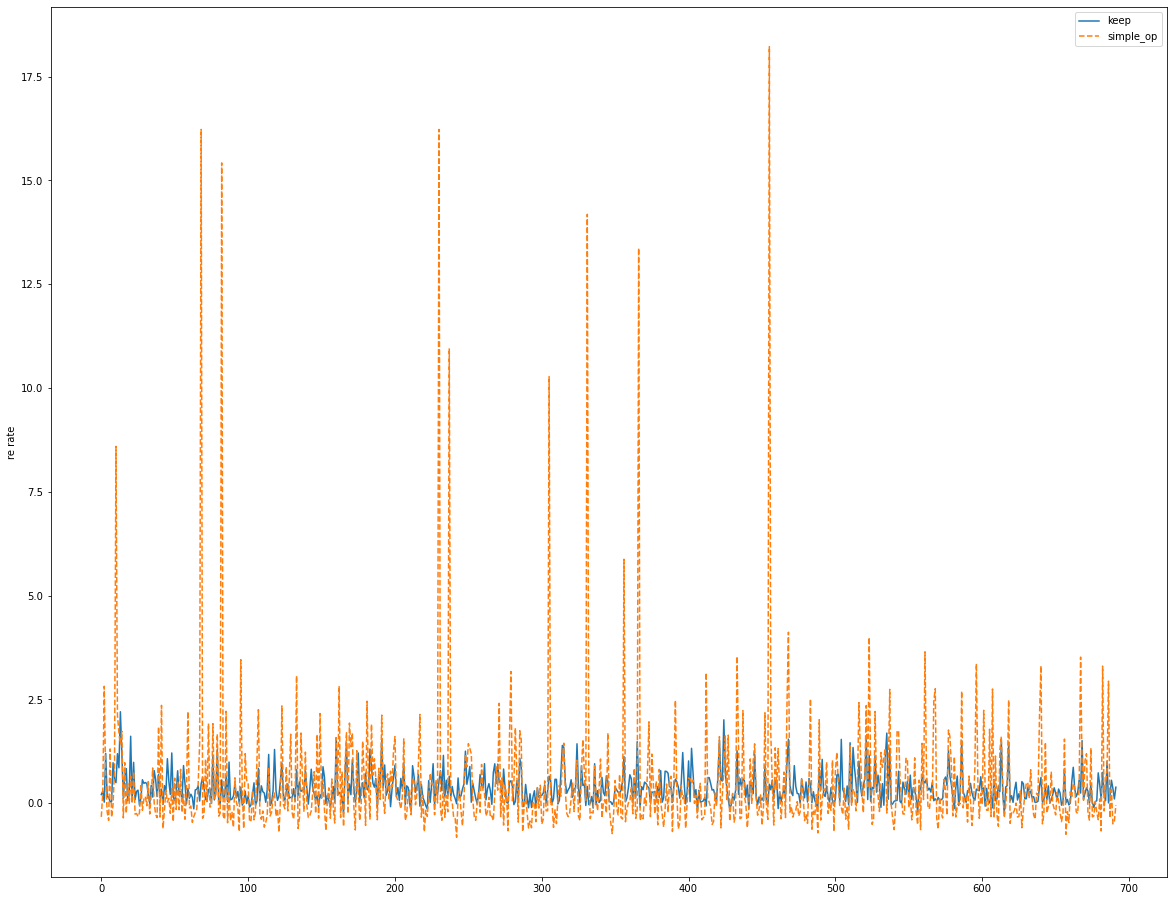

In [21]:
x = list(range(len(keep)))
y1 = keep
y2 = move_op
plt.figure(figsize=(20, 16))
plt.plot(x, y1, '-',label='keep')
plt.plot(x, y2, '--',label='simple_op')
plt.ylabel('re rate')
plt.legend()
plt.show()

策略一较大盘胜率

In [23]:
com_list1 = [keep[i] - 0.3333 for i in range(len(keep))]
count = [i for i in  com_list1 if i >0]
print('策略一较大盘胜率为',len(count)/len(com_list1))

策略一较大盘胜率为 0.44942196531791906


策略二较大盘胜率

In [24]:
com_list2 = [move_op[i] - 0.3333 for i in range(len(move_op))]
count = [i for i in  com_list2 if i >0]
print('策略二较大盘胜率为',len(count)/len(com_list2))

策略二较大盘胜率为 0.36416184971098264


策略二较策略一胜率

In [26]:
com_list3 = [move_op[i] - keep[i] for i in range(len(move_op))]
count = [i for i in  com_list3 if i >0]
print('策略二较策略一胜率为',len(count)/len(com_list3))

策略二较策略一胜率为 0.36560693641618497


下面是随机获取一个股票组合（5）的收益率源代码

import random
hs300_list = [x for x in range(0,300)]
random.shuffle(hs300_list)
hs300_choice5 = hs300_list[0:5]

hs300_choice5 = hs300_weight.loc[hs300_choice5]
print(hs300_choice5)

hs300_choice5.reset_index(inplace = True)
hs300_choice5['invest_weight'] = hs300_choice5['weight']/sum( hs300_choice5['weight']) 
for i in range(len(hs300_choice5['code'])):
    if str(hs300_choice5.loc[i,'code'])[0] != '6':
        hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SZ'
    else:
        hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SH'
        
time_on = '20200501'
time_off = '20210501'
df_ldkg = pro.daily(ts_code=str(hs300_choice5['code'][0]), start_date=time_on, end_date=time_off)
df_zssk = pro.daily(ts_code=str(hs300_choice5['code'][1]), start_date=time_on, end_date=time_off)
df_ztdq = pro.daily(ts_code=str(hs300_choice5['code'][2]), start_date=time_on, end_date=time_off)
df_zgtb = pro.daily(ts_code=str(hs300_choice5['code'][3]), start_date=time_on, end_date=time_off)
df_xbzq = pro.daily(ts_code=str(hs300_choice5['code'][4]), start_date=time_on, end_date=time_off)

#invest_vol 初始投资额
#invest_weight 投资比重
#初始投资80万  20万留作剩余现金
hs300_choice5['invest_vol'] = hs300_choice5['invest_weight'] * 1000000*0.8

#将数据按照日期进行排序
df_ldkg = df_ldkg.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_zssk = df_zssk.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_ztdq = df_ztdq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_zgtb = df_zgtb.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_xbzq = df_xbzq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)

#stock_daily——将五只股票的2020年5月6日的 ['ts_code','trade_date','open','close'] [股票代码，交易日期，开盘价，收盘价]拼接在一起
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
daily_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[0],stock_list[1][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
n = 2
while n <5:
    daily_data = pd.concat([daily_data,stock_list[n][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
    n = n + 1
stock_daily = daily_data.T

#hs300_choice5 沪深300的选择的五只股票的基本信息
hs300_choice5 = hs300_choice5.reset_index()#重置索引

hs300_choice5['ts_code'] = hs300_choice5['code']
hs300_choice5.drop('code',axis =1,inplace =True)

#将stock_daily 与 股票详细信息拼接在一起
stock_daily  = pd.merge(stock_daily,hs300_choice5[['name','invest_weight','invest_vol','ts_code']],on = 'ts_code')

stock_daily['trade_cost'] = stock_daily['invest_vol'] * 0.00025#计算交易费用
for i in stock_daily['trade_cost']:
    if i < 5:
        i = 5
stock_daily['price_in'] = stock_daily['open']
stock_daily['stock_num'] = stock_daily['invest_vol'] / stock_daily['price_in']
#求2020年5月6日的现金剩余现金 trade_cost交易费用
cash_remain = 1000000 - sum(stock_daily['trade_cost'] ) - sum(stock_daily['invest_vol'])
print('开仓剩余现金为：',cash_remain)

#final_daily 2021年4月30日的股票详细信息 和 stock_daily 同理
final_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[242],stock_list[1][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
n = 2
while n <5:
    final_data = pd.concat([final_data,stock_list[n][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
    n = n + 1
final_daily = final_data.T

stock_daily = pd.merge(stock_daily,final_daily[['ts_code','open']],on = 'ts_code')
stock_daily['price_out'] = stock_daily['open_y']
stock_daily['trade_cost_out'] = stock_daily['price_out']* stock_daily['stock_num']*(0.01 + 0.00025)#股票卖出的交易费用 包含印花税
for i in  stock_daily['trade_cost_out']:
    if i < 0:
        i = 0
stock_daily['harvest_vol'] = stock_daily['price_out']* stock_daily['stock_num']

#21年4月30日卖出股票 计算剩余现金
cash_remain = cash_remain -sum(stock_daily['trade_cost_out']) + sum(stock_daily['harvest_vol'])
print('平仓剩余现金为：',cash_remain)
mark_1 = cash_remain
#策略1收益率
mark_rate_1 = mark_1/1000000 - 1
print('策略1收益率为',mark_rate_1)

############计算均线
# 简单平均
def smaCal(tsPrice, k):  # 输入价格序列,Series
    Sma = pd.Series(np.nan, index = list(range(len(tsPrice))))
    for i in range(k - 1, len(tsPrice)):
        Sma[i] = sum(tsPrice[(i - k + 1):(i + 1)]) / k
    Sma.index = tsPrice.index
    return (Sma)

# 加权平均
def wmaCal(tsPrice, weight):  # 输入价格序列,Series
    k = len(weight)
    arrWeight = np.array(weight)
    Wma = pd.Series(np.nan, index = list(range(len(tsPrice))))
    for i in range(k - 1, len(tsPrice.index)):
        Wma[i] = sum(arrWeight * tsPrice[(i - k + 1):(i + 1)])
    Wma.index = tsPrice.index
    return (Wma)

def _ema(tsprice):
    temple = tsprice.index
    tsprice.index = list(range(len(tsprice)))
    N = len(tsprice)
    alpha = 2/(N+1)
    data = np.zeros(len(tsprice))
    for i in range(len(data)):
        data[i] = tsprice[i] if i==0 else alpha*tsprice[i]+(1-alpha)*data[i-1]
    return data[-1]
def ewmaCal(tsprice,period):
    temple = tsprice.index
    tsprice.index = list(range(len(tsprice)))
    data = pd.Series(np.nan ,index = list(range(len(tsprice))))
    for i in range(period-1,len(tsprice)):
        data[i] = _ema(tsprice[i+1-period:i+1])
    data.index = temple
    return data

for i in stock_list:
    i.index = i['trade_date']
    
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
df_ldkg_mean5 = df_ldkg[['trade_date','close']]

#简单平均
df_ldkg_mean5 = smaCal(df_ldkg_mean5['close'],5)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)
#加权平均
df_ldkg_mean5 = df_ldkg[['trade_date','close']]
weight = [0.10,0.15,0.20,0.25,0.30]#权重列表      
df_ldkg_mean5 = wmaCal(df_ldkg_mean5['close'],weight)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

# 指数移动平均
df_ldkg_mean5 = df_ldkg[['trade_date','close']]    
df_ldkg_mean5 = ewmaCal(df_ldkg_mean5['close'],period=5)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_simple5 = smaCal(df_ldkg['close'],5)
df_zssk_simple5 = smaCal(df_zssk['close'],5)
df_ztdq_simple5 = smaCal(df_ztdq['close'],5)
df_zgtb_simple5 = smaCal(df_zgtb['close'],5)
df_xbzq_simple5 = smaCal(df_xbzq['close'],5)
stockprice_simple5 = pd.DataFrame([df_ldkg_simple5,df_zssk_simple5,df_ztdq_simple5,df_zgtb_simple5,df_xbzq_simple5])
stockprice_simple5 = stockprice_simple5.T
stockprice_simple5.index = df_ldkg['trade_date']
stockprice_simple5.columns = ['df_ldkg_simple5','df_zssk_simple5','df_ztdq_simple5','df_zgtb_simple5','df_xbzq_simple5']

df_ldkg_simple20 = smaCal(df_ldkg['close'],20)
df_zssk_simple20 = smaCal(df_zssk['close'],20)
df_ztdq_simple20 = smaCal(df_ztdq['close'],20)
df_zgtb_simple20 = smaCal(df_zgtb['close'],20)
df_xbzq_simple20 = smaCal(df_xbzq['close'],20)
stockprice_simple20 = pd.DataFrame([df_ldkg_simple20,df_zssk_simple20,df_ztdq_simple20,df_zgtb_simple20,df_xbzq_simple20])
stockprice_simple20 = stockprice_simple20.T
stockprice_simple20.index = df_ldkg['trade_date']
stockprice_simple20.columns = ['df_ldkg_simple20','df_zssk_simple20','df_ztdq_simple20','df_zgtb_simple20','df_xbzq_simple20']

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_mean5 = ewmaCal(df_ldkg['close'],period=5)
df_zssk_mean5 = ewmaCal(df_zssk['close'],period=5)
df_ztdq_mean5 = ewmaCal(df_ztdq['close'],period=5)
df_zgtb_mean5 = ewmaCal(df_zgtb['close'],period=5)
df_xbzq_mean5 = ewmaCal(df_xbzq['close'],period=5)
stockprice_mean5 = pd.DataFrame([df_ldkg_mean5,df_zssk_mean5,df_ztdq_mean5,df_zgtb_mean5,df_xbzq_mean5])
stockprice_mean5 = stockprice_mean5.T
stockprice_mean5.index = df_ldkg['trade_date']
stockprice_mean5.columns = ['df_ldkg_mean5','df_zssk_mean5','df_ztdq_mean5','df_zgtb_mean5','df_xbzq_mean5']

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_mean20 = ewmaCal(df_ldkg['close'],period=20)
df_zssk_mean20 = ewmaCal(df_zssk['close'],period=20)
df_ztdq_mean20 = ewmaCal(df_ztdq['close'],period=20)
df_zgtb_mean20 = ewmaCal(df_zgtb['close'],period=20)
df_xbzq_mean20 = ewmaCal(df_xbzq['close'],period=20)
stockprice_mean20 = pd.DataFrame([df_ldkg_mean20,df_zssk_mean20,df_ztdq_mean20,df_zgtb_mean20,df_xbzq_mean20])
stockprice_mean20 = stockprice_mean20.T
stockprice_mean20.columns = ['df_ldkg_mean20','df_zssk_mean20','df_ztdq_mean20','df_zgtb_mean20','df_xbzq_mean20']
stockprice_mean20.index = df_ldkg['trade_date']

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg = df_ldkg[['ts_code','open','close']]
df_zssk = df_zssk[['ts_code','open','close']]
df_ztdq = df_ztdq[['ts_code','open','close']]
df_zgtb = df_zgtb[['ts_code','open','close']]
df_xbzq = df_xbzq[['ts_code','open','close']]

#将每个股票的各种均线合并到一个表中
merge_list = [df_ldkg_mean5,df_ldkg_mean20,df_ldkg_simple5,df_ldkg_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_ldkg.index
    
for df  in merge_list:
    df_ldkg = pd.merge(df_ldkg,df,on = 'trade_date')
df_ldkg.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

df_ldkg.reset_index(inplace = True)

df_ldkg['trade_cost'] = 0
df_ldkg['tax'] = 0
df_ldkg['capital'] = 81250.00 #单只股票的总价值 包括买卖盈亏 但不包括手续费 税费
df_ldkg['invest_vol'] = 81250.00#持仓股票价值
df_ldkg['stock_num'] = 12675.51#持仓股票数量

df_ldkg['simple_trend'] = df_ldkg['simple5'] - df_ldkg['simple20']

#依据前两日短期均线和长期均线的交叉 ，向上突破 信号 signal 为买入1  向下突破 信号signal 为-1   否则维持不变 signal 0 
for x in range(2,len(df_ldkg['simple_trend'])):
    if df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] < 0 :
        df_ldkg.loc[x,'simple_signal'] = -1
    elif df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] > 0:
        df_ldkg.loc[x,'simple_signal'] = 1
    else:
        df_ldkg.loc[x,'simple_signal'] = 0
        
#依据信号股票的买入卖出  手续费trade_cost 税金 tax 单独累加计算   capital invest_vol stock_num 等持仓数据依据信号signal 更新
for rank in range(1,len(df_ldkg['simple_signal'])):
    if df_ldkg.loc[rank ,'simple_signal'] == -1 :
            df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] - 81250.00
            df_ldkg.loc[rank ,'invest_vol'] = 0
            if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
            else:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
            df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.01
            df_ldkg.loc[rank ,'stock_num'] = 0
    elif df_ldkg.loc[rank ,'simple_signal'] == 1:
            df_ldkg.loc[rank ,'invest_vol'] = 81250.00
            df_ldkg.loc[rank ,'stock_num'] = df_ldkg.loc[rank ,'invest_vol']/df_ldkg.loc[rank ,'open']
            df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital']
            if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
            else:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
            df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax']
    else:
        df_ldkg.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = df_ldkg.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
        
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
merge_list = [df_zssk_mean5,df_zssk_mean20,df_zssk_simple5,df_zssk_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_zssk.index
for df  in merge_list:
    df_zssk = pd.merge(df_zssk,df,on = 'trade_date')
df_zssk.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_ztdq_mean5,df_ztdq_mean20,df_ztdq_simple5,df_ztdq_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_ztdq.index
for df  in merge_list:
    df_ztdq = pd.merge(df_ztdq,df,on = 'trade_date')
df_ztdq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_zgtb_mean5,df_zgtb_mean20,df_zgtb_simple5,df_zgtb_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_zgtb.index
for df  in merge_list:
    df_zgtb = pd.merge(df_zgtb,df,on = 'trade_date')
df_zgtb.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_xbzq_mean5,df_xbzq_mean20,df_xbzq_simple5,df_xbzq_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_xbzq.index
for df  in merge_list:
    df_xbzq = pd.merge(df_xbzq,df,on = 'trade_date')
df_xbzq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

#依据以上的代码定义一个依据简单平均均线的更新股票每日数据的函数
def simple_stockdaily(data,invest_vol,stock_num):
    data.reset_index(inplace = True)
    data['trade_cost'] = 0
    data['tax'] = 0
    data['capital'] = invest_vol
    data['invest_vol'] = invest_vol
    data['stock_num'] = stock_num
    data['simple_trend'] = data['simple5'] - data['simple20']
    for x in range(2,len(data['simple_trend'])):
        if data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] < 0 :
            data.loc[x,'simple_signal'] = -1
        elif data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] > 0:
            data.loc[x,'simple_signal'] = 1
        else:
            data.loc[x,'simple_signal'] = 0
    for rank in range(1,len(data['simple_signal'])):
        if data.loc[rank ,'simple_signal'] == -1 :
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                data.loc[rank ,'invest_vol'] = 0
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                data.loc[rank ,'stock_num'] = 0
        elif data.loc[rank ,'simple_signal'] == 1:
                data.loc[rank ,'invest_vol'] = invest_vol
                data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
        else:
            data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
    return data

##依据以上的代码定义一个依据指数均线的更新股票每日数据的函数
def mean_stockdaily(data,invest_vol,stock_num):
    data.reset_index(inplace = True)
    data['trade_cost'] = 0
    data['tax'] = 0
    data['capital'] = invest_vol
    data['invest_vol'] = invest_vol
    data['stock_num'] = stock_num
    data['mean_trend'] = data['mean5'] - data['mean20']
    for x in range(2,len(data['mean_trend'])):
        if data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] < 0 :
            data.loc[x,'mean_signal'] = -1
        elif data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] > 0:
            data.loc[x,'mean_signal'] = 1
        else:
            data.loc[x,'mean_signal'] = 0
    for rank in range(1,len(data['simple_signal'])):
        if data.loc[rank ,'mean_signal'] == -1 :
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                data.loc[rank ,'invest_vol'] = 0
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                data.loc[rank ,'stock_num'] = 0
        elif data.loc[rank ,'mean_signal'] == 1:
                data.loc[rank ,'invest_vol'] = invest_vol
                data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
        else:
            data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
    return data

#stock_re['remain_capital_sum'] 剩余现金的每日dataframe 依据以上的函数实现
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_zssk = simple_stockdaily(df_zssk,162500.00,8699.14)
df_ztdq = simple_stockdaily(df_ztdq,125000.00,5351.03)
df_zgtb = simple_stockdaily(df_zgtb,368750.00,10757.00)
df_xbzq = simple_stockdaily(df_xbzq,62500.00,8311.17)
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
df_ldkg_re = df_ldkg[['remain_capital']]
df_zssk_re = df_zssk[['remain_capital']]
df_ztdq_re = df_ztdq[['remain_capital']]
df_zgtb_re = df_zgtb[['remain_capital']]
df_xbzq_re = df_xbzq[['remain_capital']]
cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
stock_re.columns = cols
stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
stock_re.index = df_ldkg['trade_date']

#stock_to['total_capital_sum'] 股票总价值的d每日ataframe更新 依据以上的函数实现
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
df_ldkg_to = df_ldkg[['total_capital']]
df_zssk_to = df_zssk[['total_capital']]
df_ztdq_to = df_ztdq[['total_capital']]
df_zgtb_to = df_zgtb[['total_capital']]
df_xbzq_to = df_xbzq[['total_capital']]
cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
stock_to.columns = cols
stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']

#抠出简单平均信号的收益率
mark_2 = stock_to['total_capital_sum'][242]
mark_rate_2 = mark_2/1000000 - 1
print('简单平均操作收益率为',mark_rate_2)
stock_to.index = df_ldkg['trade_date']
simple_rev = np.array(stock_to['total_capital_sum'])#这个simple_rev 是简单平均均线策略的每日收益的序列

#以下实现的原理和简单平均相同
df_ldkg = mean_stockdaily(df_ldkg,81250.00,11363.64)
df_zssk = mean_stockdaily(df_zssk,162500.00,8699.14)
df_ztdq = mean_stockdaily(df_ztdq,125000.00,5351.03)
df_zgtb = mean_stockdaily(df_zgtb,368750.00,10757.00)
df_xbzq = mean_stockdaily(df_xbzq,62500.00,8311.17)###算出每一个股票的
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
df_ldkg_re = df_ldkg[['remain_capital']]
df_zssk_re = df_zssk[['remain_capital']]
df_ztdq_re = df_ztdq[['remain_capital']]
df_zgtb_re = df_zgtb[['remain_capital']]
df_xbzq_re = df_xbzq[['remain_capital']]
cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
stock_re.columns = cols
stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
stock_re.index = df_ldkg['trade_date']

stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
df_ldkg_to = df_ldkg[['total_capital']]
df_zssk_to = df_zssk[['total_capital']]
df_ztdq_to = df_ztdq[['total_capital']]
df_zgtb_to = df_zgtb[['total_capital']]
df_xbzq_to = df_xbzq[['total_capital']]
cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
stock_to.columns = cols
stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']

#抠出移动平均的收益率
mark_3 = stock_to['total_capital_sum'][242]
mark_rate_3 = mark_3/1000000 - 1
print('移动平均操作收益率为',mark_rate_2)
stock_to.index = df_ldkg['trade_date']
mean_rev = np.array(stock_to['total_capital_sum'])#这个mean_rev 是指数平均均线策略的每日收益的序列